In [1]:
from qiskit import QuantumCircuit, assemble
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.quantum_info import Clifford, random_clifford
from math import sqrt, pi
import time
import torch as tc
from Library.Tools import *
import numpy as np
from Library.PhysModule import multi_mags_from_states
from Library.PhysModule import reduced_density_matrces as PhyRDM

# 函数定义

In [2]:
def get_quantum_gates_and_qubits(qc):
    gates_info = []
    for gate in qc.data:
        gate_name = gate.name  # 获取量子门的名称
        qubits = gate.qubits  # 获取作用的比特
        gates_info.append((gate_name, [qc.qubits.index(qubit) for qubit in qubits]))  # 记录量子门及其作用的比特索引
    return gates_info


In [3]:
def convert_qiskit_circuit_to_usual_gates(qiskit_circuit):
    x_gate = tc.tensor([[0, 1], [1, 0]], dtype=tc.complex64)
    y_gate = tc.tensor([[0, -1j], [1j, 0]], dtype=tc.complex64)
    z_gate = tc.tensor([[1, 0], [0, -1]], dtype=tc.complex64)
    s_gate = tc.tensor([[1, 0], [0, 1j]], dtype=tc.complex64)
    sdg_gate = tc.tensor([[1, 0], [0, -1j]], dtype=tc.complex64)
    h_gate = tc.tensor([[1/(2**0.5), 1/(2**0.5)], [1/(2**0.5), -1/(2**0.5)]], dtype=tc.complex64)

    cnot_gate = tc.tensor([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]], dtype=tc.complex64).reshape(2, 2, 2, 2)
    swap_gate = tc.tensor([[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]], dtype=tc.complex64).reshape(2, 2, 2, 2)

    gate_dict = {
        'x': x_gate,
        'y': y_gate,
        'z': z_gate,
        's': s_gate,
        'sdg': sdg_gate,
        'h': h_gate,
        'cx': cnot_gate,
        'swap': swap_gate
    }

    gates_info = get_quantum_gates_and_qubits(qiskit_circuit)
    gate_list = list(gate_dict.values())
    gate_names = list(gate_dict.keys())

    which_where = []
    for gate_name, qubit_indices in gates_info:
        # print(f"Gate: {gate_name}, Qubits: {qubit_indices}")
        which_where.append([gate_names.index(gate_name)] + qubit_indices)
    
    return gate_names, gate_list, which_where


In [4]:
def generate_unitary_2_design_states(number:int, n_qubit:int):
    state = tc.zeros((2**n_qubit), dtype=tc.complex64)
    state[0] = 1 + 0.j
    state = state.reshape([2] * n_qubit)
    state = state.unsqueeze(0)
    state_list = list()
    for i in range(number):
        cliff = random_clifford(n_qubit)
        qc = cliff.to_circuit()
        gate_names, gate_list, which_where = convert_qiskit_circuit_to_usual_gates(qc)
        rand_state = pure_states_evolution(state, gate_list, which_where)
        state_list.append(rand_state)
    u2d_states = tc.cat(state_list, dim=0)
    return u2d_states


In [5]:
def measure(state):
    shape = state.shape
    state = state.reshape(-1)
    probabilities = tc.abs(state) ** 2
    # 根据概率分布进行测量
    measured_index = tc.multinomial(probabilities, 1, replacement=True).item()  # 进行测量
    measured_state = tc.zeros_like(state)
    measured_state[measured_index] = 1  # 设置对应的量子态为1

    return measured_state.reshape(shape)


In [6]:
def measure_n_times(state, number:int):
    '''
    返回测量n次得到的平均密度矩阵
    '''
    shape = state.shape
    state = state.reshape(-1)
    probabilities = tc.abs(state) ** 2
    # 根据概率分布进行多次测量
    measured_indices = tc.multinomial(probabilities, number, replacement=True)  # 进行多次测量
    # 统计每个测量结果的出现次数
    counts = tc.bincount(measured_indices, minlength=state.shape[0])
    pd = counts / tc.sum(counts)
    avg_state = tc.sqrt(pd)
    avg_rho = tc.diag(pd)
    return avg_state.reshape(shape).to(dtype=state.dtype)

In [7]:
from qiskit.quantum_info import Statevector

def tensor_to_qiskit_state(states):
    shape = states.shape
    states = states.reshape([shape[0], -1])
    states_vector_np = states.numpy()

    # 创建 Qiskit 的 Statevector 对象
    qiskit_states = [Statevector(state) for state in states_vector_np]  # BEGIN:
    
    return qiskit_states  # END:


In [8]:
from qiskit_aer import AerSimulator
from qiskit import transpile
from concurrent.futures import ThreadPoolExecutor

def sample_classical_shadow_with_clifford_circuit(n_qubit, states, num_sample=1000, simulator=None):
    if simulator is None:
        simulator = AerSimulator()  # 如果没有传入模拟器，则创建一个新的实例

    # 将tensor转换为qiskit的state
    q_states = tensor_to_qiskit_state(states)

    # 生成随机Clifford circuit，并对state作用
    rc = random_clifford(n_qubit)
    
    with ThreadPoolExecutor() as executor:
        final_states = list(executor.map(lambda state: state.evolve(rc), q_states))
    final_states = [state.evolve(rc) for state in q_states]

    # 生成一个测量量子线路，对作用后的态进行测量
    qc = QuantumCircuit(n_qubit, n_qubit)
    counts_list = []
    for i, state in enumerate(final_states):
        norm = np.linalg.norm(state.data)
        state = state.data / norm
        qc.initialize(state, qc.qubits)
        qc.measure(list(range(len(qc.qubits))), list(range(len(qc.qubits))))

        # 编译量子电路以适应模拟器
        compiled_circuit = transpile(qc, simulator)

        # 执行量子电路
        try:
            result = simulator.run(compiled_circuit, shots=int(num_sample)).result()  # 确保 num_sample 是整数
        except Exception as e:
            print(f"Error during simulation: {e}")
            return None

        counts = result.get_counts(qc)
        # print(i, counts)
        counts_list.append(counts)

    # 从counts中生成对应的量子态
    def generate_state_from_counts(counts):
        key = list(counts.keys())[0]
        state_vector = tc.zeros(2**len(key), dtype=states.dtype)
        for key, count in counts.items():
        # Convert the measurement result (key) to a quantum state
            index = int(key, 2)  # Convert binary string to integer index
            state_vector[index] = count  # Set the corresponding index to 1
        state_vector = state_vector / tc.norm(state_vector)  # Normalize the state
        return state_vector

    b_states_list = []
    # Generate quantum states from counts
    for i, counts in enumerate(counts_list):  # Assuming counts_list contains the counts from each measurement
        measured_state = generate_state_from_counts(counts)
        b_states_list.append(measured_state)

    b_states = tensor_to_qiskit_state(tc.stack(b_states_list, dim=0))

    # 获取 rc 的逆操作，并作用在测量得到的态上
    rc_inverse = rc.adjoint()
    with ThreadPoolExecutor() as executor:
        sigma_states = list(executor.map(lambda state: state.evolve(rc_inverse), b_states)) # 将逆线路作用在b_states上
    # sigma_states = [state.evolve(rc_inverse) for state in b_states]  

    # 计算测量得到的classical shadow
    Eye = tc.eye(2**n_qubit, dtype=states.dtype).numpy()
    from qiskit.quantum_info import DensityMatrix
    rho_samples = [(2**n_qubit + 1) * DensityMatrix(sigma) - Eye for sigma in sigma_states]
    rho_samples = [tc.from_numpy(rho.data) for rho in rho_samples]

    return tc.stack(rho_samples, dim=0).to(dtype=states.dtype, device=states.device)


In [9]:
n_qubit = 5
states = tc.rand((3, 2**n_qubit), dtype=tc.complex64)
norm = tc.einsum('na, na->n', states, states.conj()).real
norm = tc.sqrt(norm)
norm = norm.unsqueeze(1)
states = states / norm

rho_samples = sample_classical_shadow_with_clifford_circuit(n_qubit=n_qubit, states=states, num_sample=10000)
print(rho_samples)
print(rho_samples.shape)

tensor([[[ 1.1043+8.2481e-18j,  1.0524+2.9219e-01j,  1.4154+8.5612e-01j,
           ..., -1.2532+8.4022e-02j,  1.0844-7.6269e-01j,
          -1.5362-1.0771e-01j],
         [ 1.0524-2.9219e-01j, -0.4331+3.0321e-18j,  0.8267+2.3162e-01j,
           ..., -0.6151+2.1604e-01j,  0.4364-5.3201e-01j,
          -0.7832+1.5944e-01j],
         [ 1.4154-8.5612e-01j,  0.8267-2.3162e-01j,  0.3004-9.2133e-18j,
           ..., -0.8088+5.6639e-01j,  0.4191-9.5420e-01j,
          -1.0771+5.5253e-01j],
         ...,
         [-1.2532-8.4022e-02j, -0.6151-2.1604e-01j, -0.8088-5.6639e-01j,
           ..., -0.2503+8.8634e-18j, -0.6763+4.1093e-01j,
           0.9106+1.2548e-01j],
         [ 1.0844+7.6269e-01j,  0.4364+5.3201e-01j,  0.4191+9.5420e-01j,
           ..., -0.6763-4.1093e-01j, -0.1647+5.5497e-20j,
          -0.7526-6.1228e-01j],
         [-1.5362+1.0771e-01j, -0.7832-1.5944e-01j, -1.0771-5.5253e-01j,
           ...,  0.9106-1.2548e-01j, -0.7526+6.1228e-01j,
           0.1270-3.5877e-18j]],

      

In [10]:
import time
def loss_sample_fide(psi_real:tc.Tensor, psi_pred:tc.Tensor, num_basis:int=30, k=10, num_sample:int=100000):
    assert psi_pred.shape == psi_real.shape
    assert psi_pred.device == psi_real.device
    assert psi_pred.dtype == psi_real.dtype

    psi_pred.requires_grad_()
    num_states = psi_pred.shape[0]
    n_qubit = len(psi_real.shape) - 1
    avg_rho = 0
    number = num_basis * k
    avg_fidelity = 0
    # rho = tc.einsum('a, b -> ab', state.reshape(-1), state.reshape(-1).conj())
    for i in range(number):
        t1 = time.time()
        rho_sample = sample_classical_shadow_with_clifford_circuit(states=psi_real, n_qubit=n_qubit, num_sample=num_sample)
        t2 = time.time()
        print(t2-t1)
        avg_rho = avg_rho + rho_sample
        if i % num_basis == num_basis-1:
            avg_rho = avg_rho / num_basis
            fidelity = tc.einsum('na, nab, nb ->n', psi_pred.reshape([num_states,-1]).conj(), avg_rho, psi_pred.reshape([num_states,-1]))
            avg_fidelity = avg_fidelity + fidelity
            avg_rho = 0
    avg_fidelity = avg_fidelity / k
    loss = tc.norm(tc.ones_like(avg_fidelity) - avg_fidelity)
    return loss

In [11]:
def rand_states(n_qubit, states_num):
    shape = [states_num] + [2]*n_qubit
    states = tc.rand((states_num, 2**n_qubit), dtype=tc.complex64)
    norm = tc.einsum('na, na->n', states, states.conj()).real
    norm = tc.sqrt(norm)
    norm = norm.unsqueeze(1)
    states = states / norm
    return states.reshape(shape)

n_qubit = 5
real = rand_states(n_qubit=n_qubit, states_num=100)
pred = rand_states(n_qubit=n_qubit, states_num=100)

import time


t1 = time.time()
sample_classical_shadow_with_clifford_circuit(n_qubit=n_qubit, states=real, num_sample=100000)
t2 = time.time()
print(t2-t1)

t1 = time.time()
loss = loss_sample_fide(psi_real=real, psi_pred=pred, num_basis=1, k=1, num_sample=100000)
t2 = time.time()
print(t2-t1)


1302.2650871276855
1363.5766651630402
1363.685971736908


In [12]:
def sample_classical_shadow(aim_state, n_qubit, num_sample=10000):
    '''
    state的形状为[number_of_states]+[2]*n_qubit
    '''
    cliff = random_clifford(n_qubit)
    qc = cliff.to_circuit()
    gate_names, gate_list, which_where = convert_qiskit_circuit_to_usual_gates(qc)
    U_state = pure_states_evolution(aim_state, gate_list, which_where)
    # b_state = measure(U_state)
    b_state = measure_n_times(U_state, num_sample)

    inverse_qc = qc.inverse()
    gate_names, gate_list, which_where = convert_qiskit_circuit_to_usual_gates(inverse_qc)
    sigma_state = pure_states_evolution(b_state, gate_list, which_where)
    sigma = tc.einsum('a, b -> ab', sigma_state.reshape(-1), sigma_state.reshape(-1).conj())
    Eye = tc.eye(2**n_qubit, dtype=tc.complex64)
    rho_sample = (2**n_qubit + 1) * sigma - Eye
    return rho_sample


In [13]:
def matrix_sqrt(A, tol=1e-6):
    """
    计算复数矩阵 A 的平方根，使用特征值分解。
    
    参数：
    A (torch.Tensor): 复数矩阵。
    
    返回：
    torch.Tensor: 复数矩阵 A 的平方根。
    """
    # 进行特征值分解
    eigenvalues, eigenvectors = tc.linalg.eigh(A)
    
    # 对特征值进行裁剪：小于 tol 的特征值设置为零
    eigenvalues = tc.where(tc.abs(eigenvalues) < tol, tc.tensor(0.0, dtype=eigenvalues.dtype), eigenvalues)

    # 计算特征值的平方根
    eigenvalues_sqrt = tc.sqrt(eigenvalues)
    
    # 构造平方根矩阵
    A_sqrt = eigenvectors @ tc.diag(eigenvalues_sqrt).to(dtype=tc.complex64) @ eigenvectors.T.conj()
    
    return A_sqrt


In [14]:
def fidelity_density_matrices(rho, sigma):
    """
    计算两个复数密度矩阵 rho 和 sigma 之间的保真度。
    
    参数：
    rho (torch.Tensor): 复数密度矩阵 rho。
    sigma (torch.Tensor): 复数密度矩阵 sigma。
    
    返回：
    float: 两个密度矩阵之间的保真度。
    """
    # 计算 sqrt(rho)
    sqrt_rho = matrix_sqrt(rho)  # 使用自定义的 matrix_sqrt 函数计算复数矩阵的平方根
    
    # 计算 sqrt(rho) * sigma * sqrt(rho)
    product = tc.matmul(tc.matmul(sqrt_rho, sigma), sqrt_rho)
    
    # 计算 sqrt(sqrt(rho) * sigma * sqrt(rho))
    sqrt_product = matrix_sqrt(product)  # 计算 sqrt(sqrt(rho) * sigma * sqrt(rho))
    
    # 计算保真度 F = Tr(sqrt(sqrt(rho) * sigma * sqrt(rho)))
    return tc.abs(tc.trace(sqrt_product))**2


In [15]:
def reduced_density_matrix(rho:tc.Tensor, pos:list, length:int):
    '''
    求关于pos的约化密度矩阵。例如 pos=[0] 表示求关于第0个指标的约化密度矩阵，返回一个 (2, 2) 的矩阵
    '''
    # length = int(np.log2(rho.shape[0]))
    rho = rho.reshape([2] * (length*2))
    perm_0 = [_ for _ in range(length)]
    perm_1 = [_ for _ in range(length, 2*length)]
    dim_a = 1
    dim_b = 2 ** length
    pos_ = []
    for i in pos:
        pos_.append(i + length)
        perm_0.remove(i)
        perm_1.remove(i + length)
        dim_a = dim_a * 2
        dim_b = int(dim_b / 2)
    perm = pos + perm_0 + pos_ + perm_1
    rho_tmp = rho.permute(perm)
    rho_tmp = rho_tmp.reshape([dim_a, dim_b, dim_a, dim_b])
    reduced_rho = tc.einsum('ibjb->ij', rho_tmp)
    return reduced_rho


In [16]:
def multi_mags_from_rho(rho, length):
    # length = int(np.log2(rho.shape[0]))
    rho = rho.reshape([2] * length *2)
    sigma_x = tc.tensor([[0, 1], [1, 0]], dtype=rho.dtype)
    sigma_y = tc.tensor([[0, -1j], [1j, 0]], dtype=rho.dtype)
    sigma_z = tc.tensor([[1, 0], [0, -1]], dtype=rho.dtype)
    which_ops = [sigma_x*0.5, sigma_y*0.5, sigma_z*0.5]
    mags = tc.zeros((3, length), device=rho.device)
    for i in range(length):
        reduced_rho = reduced_density_matrix(rho, pos=[i], length=length)
        for s in range(3):
            # print(rho)
            # print(which_ops[s])
            obs = which_ops[s]
            mags[s, i] = tc.einsum('bc,cb->', reduced_rho.type(tc.complex64), obs.type(tc.complex64)).real
    return mags


In [17]:
def cal_mean_mag_on_site_index(count_state, i):
    '''
    count_state.shape is [2] * n_qubit
    '''
    n_qubit = count_state.ndim
    perm = [_ for _ in range(n_qubit)]
    perm[0] = i
    perm[i] = 0
    count_state = count_state.permute(perm)
    count_state = count_state.reshape([2, -1])
    mag_i_count = tc.sum(count_state, dim=1)
    mean_mag_i = (0.5 * mag_i_count[0] + -0.5 * mag_i_count[1]) / (mag_i_count[0] + mag_i_count[1])
    return mean_mag_i.real

# 测试shadow tomography

In [18]:
def fidelity_from_classical_shadow(state, num_sample, num_basis):
    '''
    state的形状为[number_of_states] + [2]*n_qubit
    '''
    avg_rho = 0
    number = num_basis * 11
    mean_fidelity_list = []
    # rho = tc.einsum('a, b -> ab', state.reshape(-1), state.reshape(-1).conj())
    for i in range(number):
        rho_sample = sample_classical_shadow(state, n_qubit, num_sample)
        avg_rho = avg_rho + rho_sample
        if i % num_basis == num_basis-1:
            avg_rho = avg_rho / num_basis
            fidelity = tc.einsum('a, ab, b ->', state.reshape(-1).conj(), avg_rho, state.reshape(-1)).real
            mean_fidelity_list.append(fidelity)
            avg_rho = 0
    return mean_fidelity_list

n_qubit = 10
# state = tc.rand((2**n_qubit), dtype=tc.complex64)
state = tc.rand(2, dtype=tc.complex64)
for i in range(n_qubit-1):
    state = tc.einsum('a, b -> ab', state, tc.rand(2, dtype=tc.complex64))
    state = state.reshape(-1)
state = state / tc.norm(state)
state = state.reshape([2] * n_qubit)
state = state.unsqueeze(0)
print(state.shape)

basis_list = [i for i in range(1, 30)]
fidelity = []
time_list = []
for num_basis in basis_list:
    print('num_basis = ', num_basis)
    t1 = time.time()
    mean_fidelity_list = fidelity_from_classical_shadow(state, 10000, num_basis=num_basis)
    fidelity.append(mean_fidelity_list)
    t2 = time.time()
    print(t2 - t1)
    print()
    time_list.append(t2-t1)
# multi_mags_sample = tc.stack(multi_mags_list, dim=0)
# print(multi_mags_sample.shape)
# median_multi_mags, _ = tc.median(multi_mags_sample, dim=0)
# print(median_multi_mags - multi_mags_real)

torch.Size([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
num_basis =  1
0.3706090450286865

num_basis =  2
0.518963098526001

num_basis =  3
0.8024601936340332

num_basis =  4
1.039259910583496

num_basis =  5
1.2687227725982666

num_basis =  6
1.5245633125305176

num_basis =  7
1.7383313179016113

num_basis =  8
3.830806016921997

num_basis =  9
8.437376737594604

num_basis =  10
5.836273431777954

num_basis =  11
2.6311516761779785

num_basis =  12
20.88297939300537

num_basis =  13
10.860673666000366

num_basis =  14
19.019598484039307

num_basis =  15
4.021212100982666

num_basis =  16
28.308665990829468

num_basis =  17
5.0361411571502686

num_basis =  18
4.875778436660767

num_basis =  19
4.555893182754517

num_basis =  20
4.79940128326416

num_basis =  21
4.9948954582214355

num_basis =  22
5.034968137741089

num_basis =  23
5.381208419799805

num_basis =  24
5.469603538513184

num_basis =  25
5.688448190689087

num_basis =  26
5.943541765213013

num_basis =  27
6.4174416065216064

num_bas

- 实验结果

torch.Size([1, 2, 2, 2, 2, 2])

num_basis =  3
0.23209691047668457

num_basis =  30
1.9153223037719727

num_basis =  60
3.759786605834961

num_basis =  90
6.546694755554199

num_basis =  120
8.045798540115356

num_basis =  150
9.348260164260864

num_basis =  180
10.286007642745972

num_basis =  210
15.281891584396362

num_basis =  240
25.384276151657104

num_basis =  270
25.581177473068237

num_basis =  300
35.129565954208374

num_basis =  3000
378.68991017341614

num_basis =  6000
993.3943264484406

num_basis =  9000
911.1991903781891

- 实验结果2

torch.Size([1, 2, 2, 2, 2, 2])

num_basis =  300
16.430874586105347

num_basis =  600
31.312135696411133

num_basis =  900
48.63883566856384

num_basis =  1200
63.95498204231262

num_basis =  1500
82.71075224876404

num_basis =  1800
90.55077004432678

num_basis =  2100
114.74883365631104

num_basis =  2400
134.79453921318054

num_basis =  2700
158.37383460998535

num_basis =  3000
169.26471877098083



In [ ]:
from textwrap import wrap
import matplotlib.pyplot as plt

result = np.array(fidelity)
median, std = np.median(fidelity, axis=1), result.std(axis=1)

plt.errorbar(basis_list, median, yerr=std, fmt='-o', capsize=5, label='Fidelity with Error Bars')
plt.xlabel('Number of Basis')
plt.ylabel('Fidelity of the Classical Shadow with the Real State', wrap=True)
plt.title('Fidelity with Error Bars')
plt.legend()
plt.show()

plt.close()  # Close the previous plot
plt.plot(basis_list, std, label='Standard Deviation', color='orange')
plt.xlabel('Number of Basis')
plt.ylabel('Standard Deviation of Fidelity')
plt.title('Standard Deviation of Fidelity with Number of Basis')
plt.legend()
plt.show()

plt.close()
plt.plot(basis_list, time_list)
plt.xlabel('Number of Basis')
plt.ylabel('Run Time (s)')
plt.show()

通过shadow tomography得到态保真度所需的时间随基底数量的增加呈大致线性关系

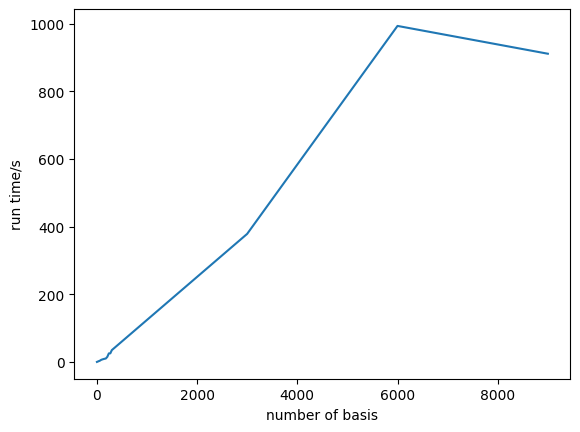

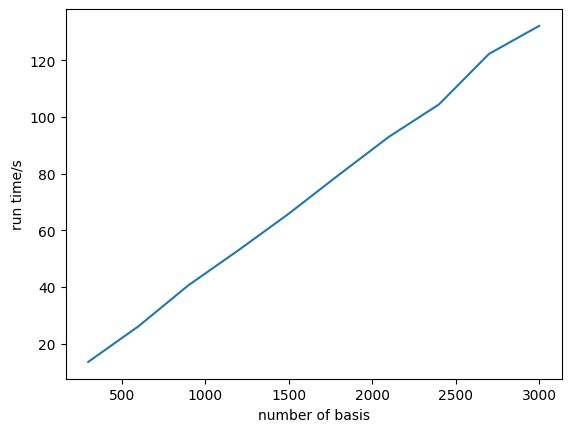

准确度随着基底数量的增加而增加，在基底数量为300时标准差大概为0.1，在基底数量为3000时大概为0.02

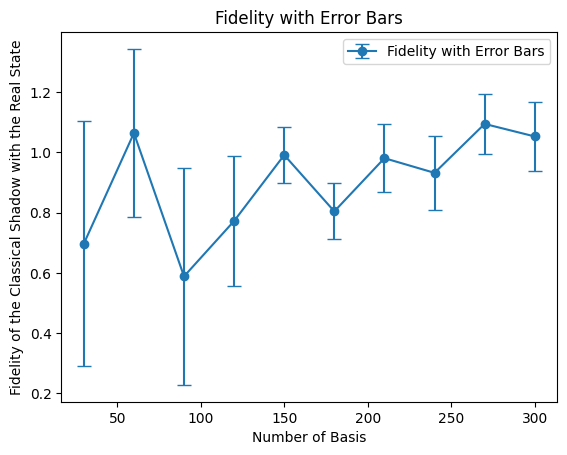
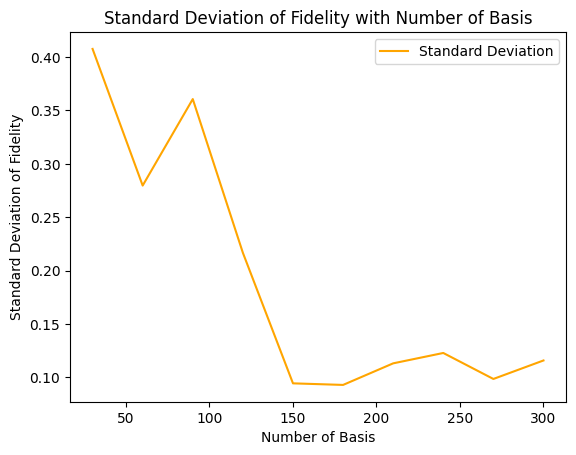

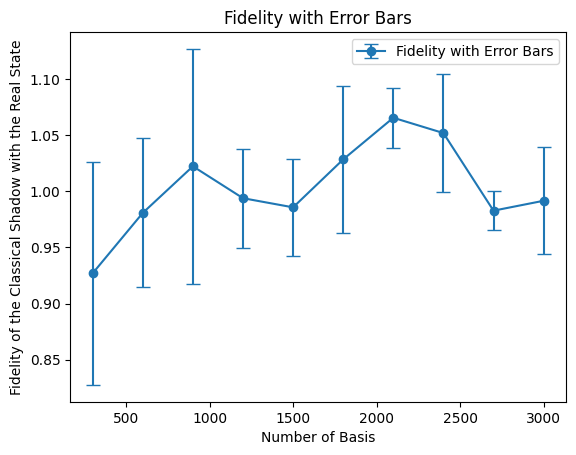
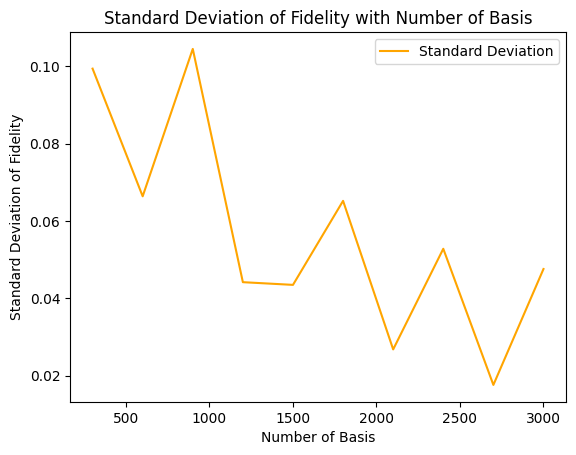

# 测试通过测量得到局域磁矩

In [ ]:
n_qubit = 5
state = tc.rand(2, dtype=tc.complex64)
for i in range(n_qubit-1):
    state = tc.einsum('a, b -> ab', state, tc.rand(2, dtype=tc.complex64))
    state = state.reshape(-1)
state = state / tc.norm(state)
state = state.reshape([2] * n_qubit)
# state = state.unsqueeze(0)
print(state.shape)

rho = tc.einsum('a, b -> ab', state.reshape(-1), state.reshape(-1).conj())

# reduced_rho = reduced_density_matrix(rho, pos=[0])
# print(reduced_rho)

# reduced_rho_ = PhyRDM(state.unsqueeze(0), pos=[0])
# print(reduced_rho - reduced_rho_[0])

multi_mags_from_rho_ = multi_mags_from_rho(rho, length=n_qubit)
# multi_mags_from_states_ = multi_mags_from_states(states=state.unsqueeze(0))
# print(multi_mags_from_rho_)
# print(multi_mags_from_states_[0])

count_state = tc.zeros_like(state)
for i in range(1024*10):
    measured_state = measure(state)
    count_state = count_state + measured_state

mean_mags = [cal_mean_mag_on_site_index(count_state=count_state, i=k) for k in range(n_qubit)]

print('-'*10 + 'mag_z from sample' + '-'*10)
print(mean_mags)
print('-'*10 + 'mag_z from calculate' + '-'*10)
print(multi_mags_from_rho_[2,:])
print('-'*10 + 'difference' + '-'*10)
print(tc.tensor(mean_mags) - multi_mags_from_rho_[2,:])


# 测试PhysModule.py中的sample_classical_shadow()

In [ ]:
from Library.PhysModule import sample_classical_shadow

n_qubit = 2

state_num = 3
shape = [state_num]+[2]*n_qubit
states = tc.rand(size=shape, dtype=tc.complex64)
states = states.reshape(shape=[state_num, -1])
print(states.shape)
states = states / tc.sqrt(tc.einsum('na, na -> n', states, states.conj()).real).unsqueeze(1)
print(states.shape)
states = states.reshape(shape)

num_sample = 100

shadow = sample_classical_shadow(aim_states=states, n_qubit=n_qubit, num_sample=num_sample)

print(tc.einsum('naa->n',shadow))

print(shadow.shape)
print(tc.norm(tc.einsum('nab->nba', shadow).conj() - shadow))

# 测试WorkFlow.TrainModel中的loss_sample_fide

In [ ]:
from WorkFlow.TrainModel import loss_sample_fide

n_qubit = 2

state_num = 5
def rand_states(n_qubit, state_num):
    shape = [state_num]+[2]*n_qubit
    states = tc.rand(size=shape, dtype=tc.complex64)
    states = states.reshape(shape=[state_num, -1])
    print(states.shape)
    states = states / tc.sqrt(tc.einsum('na, na -> n', states, states.conj()).real).unsqueeze(1)
    print(states.shape)
    states = states.reshape(shape)
    return states

real = rand_states(n_qubit, state_num)
pred = rand_states(n_qubit, state_num)

_ = tc.einsum('na, na->n',real.reshape([state_num, -1]), pred.reshape([state_num, -1]).conj())
print(tc.einsum('n, n->n', _, _.conj()).real)

avg_fidelity = loss_sample_fide(real, pred)
print(avg_fidelity)
loss = tc.norm(tc.ones_like(avg_fidelity) - avg_fidelity)/state_num
print(loss)

In [ ]:
print(tc.norm(tc.ones_like(avg_fidelity) - avg_fidelity))

In [ ]:
test_fide = loss_sample_fide(real, real)
print(tc.norm(tc.ones_like(test_fide) - test_fide))

In [ ]:
print(test_fide)

## 测试反向传播

In [ ]:
from WorkFlow.TrainModel import ADQC, train

states_1 = rand_states(5, 3)
states_2 = rand_states(5, 3)

para0 = dict()  # 默认参数
para0['test_ratio'] = 0.2  # 将部分样本划为测试集
para0['length_in'] = 5  # 数据样本维数
para0['length_out'] = 5
para0['batch_size'] = 200  # 批次大小
para0['feature_map'] = 'cossin'  # 特征映射
para0['lattice'] = 'brick'  # ADQC链接形式（brick或stair）
para0['depth'] = 4  # ADQC层数
para0['ini_way'] = 'identity'  # 线路初始化策略
para0['lr'] = 2e-3  # 初始学习率
para0['it_time'] = 1000  # 迭代次数
para0['print_time'] = 10  # 打印间隔
para0['device'] = 'cpu'
para0['dtype'] = tc.complex64

qc = ADQC(para0)

from torch.optim import Adam
optimizer = Adam(qc.parameters(), lr=para0['lr'])
pred = qc(states_1)
loss = loss_sample_fide(psi_real=states_2, psi_pred=pred, num_basis=30, k=10)

In [ ]:
loss.backward()

In [ ]:
help(qc)

In [ ]:
print(list(qc.parameters())[0].grad)

In [ ]:
optimizer.step()
optimizer.zero_grad()

In [ ]:
pred = qc(states_1)
loss = loss_sample_fide(psi_real=states_2, psi_pred=pred, num_basis=30, k=10)

In [ ]:
print(list(qc.parameters())[0].grad)

In [ ]:
print(loss.requires_grad)